# Problem 3



In [10]:
import arviz as az
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from random import sample
import seaborn as sns
import scipy.stats as ss
from scipy import optimize
from statsmodels.api import OLS # has better summary stats than sklearn's OLSb

First load the data.

In [11]:
penguin = pd.read_csv("penguins.csv")

## Part 1

In [12]:
# 3.1 normalize

min = np.min(penguin['flipper_length_mm'])
max = np.max(penguin['flipper_length_mm'])

flipper_norm = [(val - min) / (max - min) for val in penguin['flipper_length_mm']]
norm = np.array(flipper_norm) - np.array(flipper_norm).mean()
normalized = norm/norm.std()

penguin['flipper_norm'] = normalized
penguin['body_mass_kg'] = penguin['body_mass_g']/1000


print('Normalized flipper outcome: \n','\t std:', '\t',normalized.std(), '\n \t mean: ', '\t',round(normalized.mean(),10)) # std.=1, mean=0

Normalized flipper outcome: 
 	 std: 	 1.0 
 	 mean:  	 -0.0


We can check to make sure the distributions look the same.

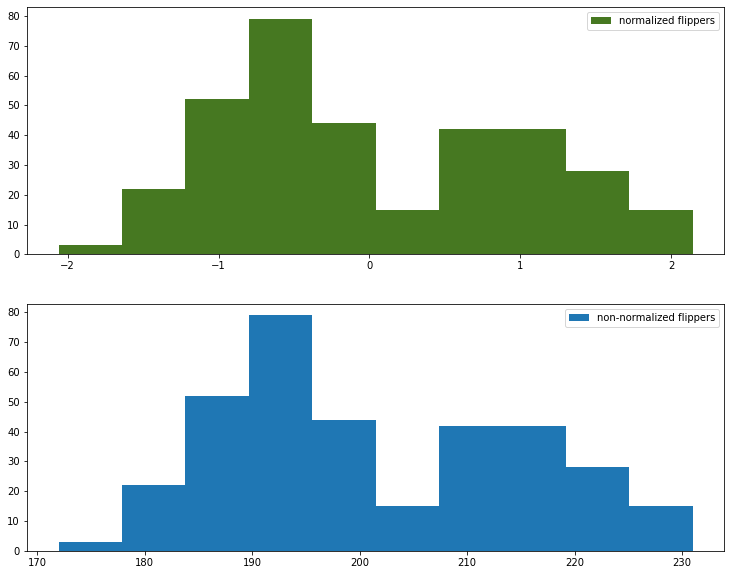

In [13]:
plt.figure(figsize=(12.5,10))
ax = plt.subplot(211)
plt.hist(penguin.flipper_norm.values, label="normalized flippers",color="#467821")
plt.legend(loc="upper right");
ax = plt.subplot(212)
plt.hist(penguin.flipper_length_mm.values,label="non-normalized flippers")
plt.legend(loc="upper right");

What about the weight distribution of the pandas?

/Users/erikweis/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


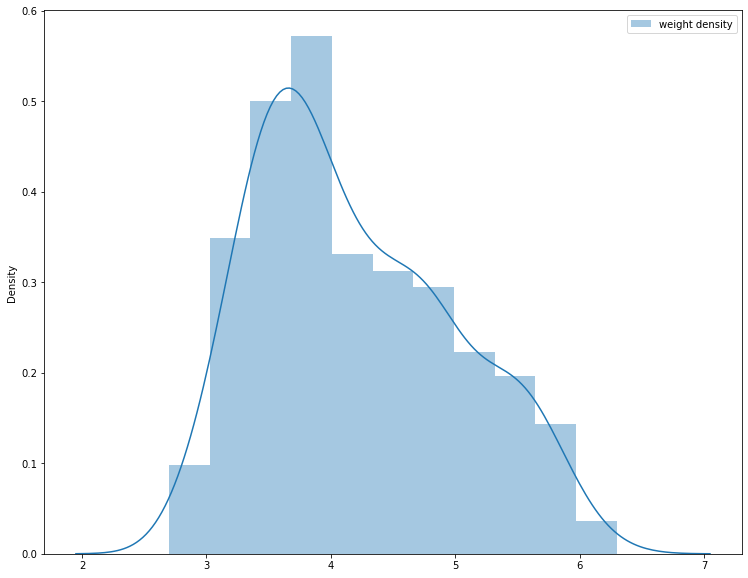

In [14]:
# curious about weight distribution
plt.figure(figsize=(12.5,10))
# plt.hist(penguin.body_mass_kg.values,label="non-normalized",bins = 50)
sns.distplot(penguin.body_mass_kg.values, label="weight density")
plt.legend(loc="upper right");

In [15]:
def generate_parameters_prior():
    return [ss.norm(50,np.sqrt(200)).rvs(), # generates alpha
            ss.norm(0,np.sqrt(200)).rvs(),  # generates beta
            ss.uniform(0,100).rvs()]  # generates var

## Part 3

We can start by creating a funcvtion that samples X. 

In [16]:
def sample_from_x(num_samples):
    return sample(list(penguin['flipper_norm']),num_samples)

In [17]:
def generate_data(alpha, beta, var, num_samples=10):
    generated_data = []
    X = sample_from_x(num_samples)
    for i in range (num_samples):
        generated_data.append(ss.norm(alpha + beta*X[i], np.sqrt(var)).rvs())
    return generated_data

Text(0, 0.5, 'penguin weight')

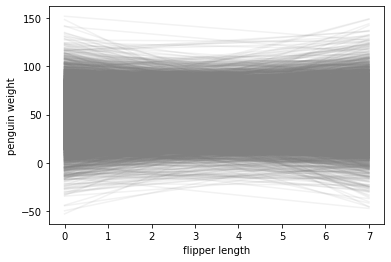

In [18]:
# PRIOR PREDICTIVE REGRESSION LINES
for i in range(1000):
  params = generate_parameters_prior()
  alpha = params[0]
  beta = params[1]
  var = params[2]

  Y0 = generate_data(alpha, beta, var)
  Y1 = generate_data(alpha, beta, var)

  plt.plot([0, 7], [Y0, Y1], c='gray', alpha=0.1)

plt.xlabel('flipper length')
plt.ylabel('penguin weight')

## Part 4

In [19]:
def log_posterior(alpha, beta, var, Y, X):
  N = len(X)
  if var > 100 or var < 0:
      return -100000000000000000000
  return (-N * np.log(var) / 2 - np.sum((Y - alpha - beta * X) ** 2) / var +     # log_likelihood
          ss.norm(50, np.sqrt(200)).logpdf(alpha) +                           # log of the prior on alpha
          ss.norm(0, np.sqrt(100)).logpdf(beta))                              # log of the prior on beta
            

def minus_log_posterior(theta):
    alpha = theta[0]
    beta = theta[1]
    var = theta[2]
    Y = penguin['body_mass_kg']
    X = penguin['flipper_norm']
    return - log_posterior(alpha, beta,var,Y,X)


fit = optimize.minimize(minus_log_posterior, [50, 0, 10])


# fit approx.
MAP = fit['x']
hess_inv  = fit['hess_inv']
approx = ss.multivariate_normal(MAP, hess_inv)

## Part 5

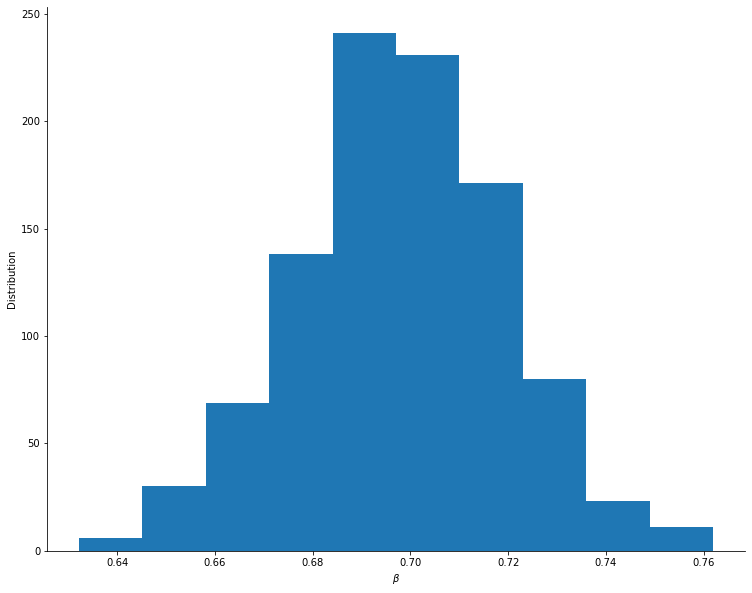

<Figure size 900x720 with 0 Axes>

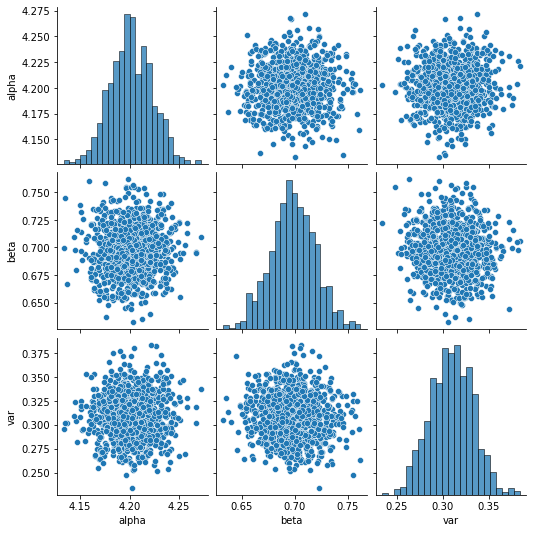

In [20]:
samples = approx.rvs(1000)

plt.figure(figsize=(12.5,10))
plt.hist(samples[:,1])
plt.ylabel('Distribution')
plt.xlabel(r'$\beta$')
sns.despine()

plt.figure(figsize=(12.5,10))
sns.pairplot(pd.DataFrame(samples, columns=['alpha', 'beta', 'var']))

## Part 6

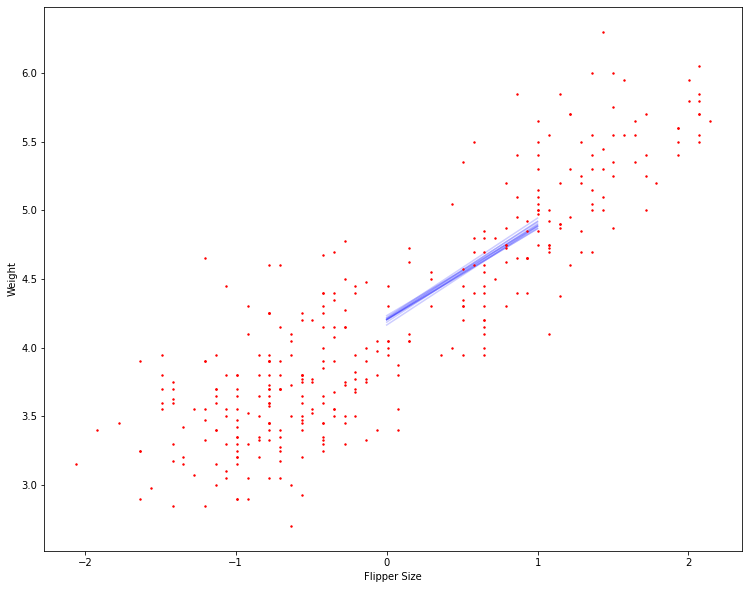

In [21]:
# data points and regression lines
plt.figure(figsize=(12.5,10))
for i in range(10):  # 10 data sets
  params = approx.rvs()
  alpha = params[0]
  beta = params[1]
  var = params[2]

  Y0 = generate_data(alpha, beta, var, 50)  # simulate 50 measurements at 0
  Y1 = generate_data(alpha, beta, var, 50)  # simulate 50 measurements at 1

  plt.plot([alpha, alpha + beta], c='blue', alpha=0.1, zorder=-100)
  plt.plot([alpha, alpha + beta], c='blue', alpha=0.1, zorder=-100)
   # plt.scatter([0] * 50 + [1] * 50, np.concatenate((Y0, Y1)), c='gray', alpha=0.1, zorder=-100)

plt.xlabel('Flipper Size')
plt.ylabel('Weight')
plt.scatter(penguin['flipper_norm'], penguin['body_mass_kg'], s=2, c='red')